In [27]:
# calculate kiwifruit in fridge; 
# read process: read 99-d for each day
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
# import tensorflow as tf
import math
# from scipy.optimize import fsolve
# from scipy.optimize import root
import scipy as scipy
from scipy.optimize import minimize
# from scipy import signal
# from scipy import linalg
# import scipy as scp
# import sympy as  syp
# from tensorflow.keras import backend as K
# from tensorflow.keras.layers import Layer
# from tensorflow.keras.models import Sequential
import os
import gc
import random

In [5]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )

        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array
        

In [6]:
dict0 = {}
for i in range(1,100):
    dict0[i] = '.\\20230210\\冷库\\Sample'+str(i)+'.txt'
dict0[0] = '.\\20230210\\冷库\\irf00.txt'

dict1 = {}
for i in range(1,100):
    dict1[i] = '.\\20230217\\冷库\\Sample'+str(i)+'.txt'
dict1[0] = '.\\20230217\\冷库\\irf00.txt'

dict2 = {}
for i in range(1,100):
    dict2[i] = '.\\20230224\\冷库\\Sample'+str(i)+'.txt'
dict2[0] = '.\\20230224\\冷库\\irf00.txt'

dict3 = {}
for i in range(1,100):
    dict3[i] = '.\\20230303\\冷库\\Sample'+str(i)+'.txt'
dict3[0] = '.\\20230303\\冷库\\irf00.txt'

dict4 = {}
for i in range(1,100):
    dict4[i] = '.\\20230310\\冷库\\Sample'+str(i)+'.txt'
dict4[0] = '.\\20230310\\冷库\\irf00.txt'

dict5 = {}
for i in range(1,100):
    dict5[i] = '.\\20230317\\冷库\\Sample'+str(i)+'.txt'
dict5[0] = '.\\20230317\\冷库\\irf00.txt'

dict6 = {}
for i in range(1,100):
    dict6[i] = '.\\20230324\\冷库\\Sample'+str(i)+'.txt'
dict6[0] = '.\\20230324\\冷库\\irf00.txt'

dictn = [dict0,dict1,dict2,dict3,dict4,dict5,dict6]

In [7]:
class analyze(object):
    def __init__(self):

        return
    def read_radius(self):
        data1 = pd.read_excel('./kiwi_data.xlsx',sheet_name=1,header=None)
        data2 = np.array(data1)
        return data2[:,1]

    def read_everyday(self,dict0,radius):    
        files = os.listdir(dict0[0][0:-10])   # 读入文件夹
        N = len(files)       # 统计文件夹中的文件个数
        scat = [None]*N
        data_480multi9 = np.zeros((N,480), dtype = float)
        time_index = np.zeros((N,480))
        radius0 = np.zeros((N-1,))
        j=0
        for i in range(0,100):
            if os.path.exists(dict0[i]):
                scat[j] = process_hyperspec(dict0[i], i)
                scat[j].read_data()
                data_480multi9[j,:] = scat[j].cal_846nm()
                time_index[j] = scat[j].return_dataframe().index
                if(i!=0):
                    radius0[j-1] = radius[i-1]
                j=j+1
            else:
                pass
        return data_480multi9,time_index,N,radius0

    def generate_h_y(self,data_480multi9,N):
        kernel0 = np.ones((10,))
        data_smooth = np.zeros((N-1,480))
        for i in range(N-1):
            data_smooth[i] = np.convolve(kernel0,data_480multi9[i+1],'same')/np.sum(kernel0)
        y = np.zeros((data_smooth.shape[0],data_smooth.shape[1]*2-1))
        y[:,0:data_smooth.shape[1]] = data_smooth
        h = np.convolve(kernel0,data_480multi9[0],'same')/np.sum(kernel0)
        return h,y
        

    

In [8]:
ana = analyze()
H = []
Y = []
TIME = []
R = []
AMOUNT_EXP = len(dictn)
for i in range(AMOUNT_EXP):
    radius = ana.read_radius()
    data_480multi9,time_index,N,radius0 = ana.read_everyday(dictn[i],radius)
    h,y = ana.generate_h_y(data_480multi9,N)
    H.append(h)
    Y.append(y)
    TIME.append(time_index)
    R.append(radius0)

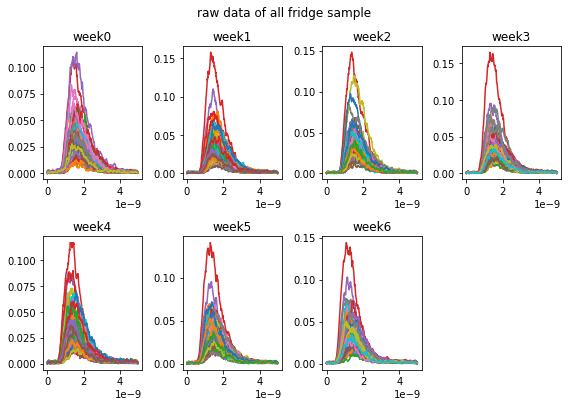

In [33]:
##########################################
fig = plt.figure(figsize = (8,8))
fig.suptitle('raw data of all fridge sample')
for i in range(AMOUNT_EXP):
    plt.subplot(3,4,i+1)
    plt.title('week'+str(i))
    for j in range(Y[i].shape[0]):
        plt.plot(time_index[i]*1e-9,Y[i][j,0:data_480multi9.shape[1]])
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)

plt.show()

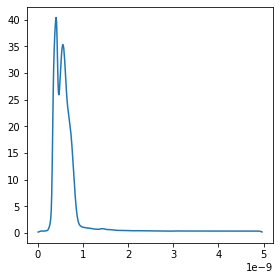

In [10]:
##########################################
fig = plt.figure(figsize = (4,4))

plt.plot(time_index[i]*1e-9,h)
# plt.title.set_text(dict0[i][9:-4])
fig.tight_layout(pad=1.1)


plt.show()

In [11]:
class calculate_miu_s1(object):
    
    def __init__(self, h, y, time_index,d):
        self.h = h
        self.y = y
        self.time = time_index
        self.d = d
        return None
    
    def transmittance(self, d, t, c, g, miu_a, miu_s):
        miu_s_prime = (1-g)*miu_s
        Z0 = 1/(miu_s_prime)
        D = 1/(3*(miu_a + miu_s_prime))
        h1 = math.pow(4*math.pi*D*c, -0.5)
        h2 = math.pow(t, -1.5)*math.exp(-miu_a*c*t)
        h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
        h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
        h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
        h6 = (3*d+Z0)*math.exp(-(math.pow(3*d+Z0, 2))/(4*D*c*t))
    #     return d,Z0,D,c,t
        return h1*h2*(h3-h4+h5-h6)
    
    
    def error_cal(self, x):
        miu_a = x[0]
        #miu_a = 69
        miu_s = x[1]
         
        # k = 0.1
        # miu_a = 0.01e2
        g = 0.85
        # d = 0.38e-3
        d = self.d
        c = 3e8/1.3314
        T = int(480)
#         time = np.array(range(1,T, 1))
#         time = time*1e-8*0.010345058455114822
        time = self.time*1e-9
        # miu_s = miu_s*1e4
        intensity1 = np.zeros((T, ), dtype = float)
        for i in range(time.shape[0] ):

            intensity1[i] = calculate_miu_s1.transmittance(self, d, time[i], c, g, miu_a, miu_s)
        
        y2 = np.convolve(intensity1, self.h)
        self.intensity = intensity1
        self.y_convolved = y2
        y2 = y2/max(abs(y2))
        y3 = self.y/max(abs(self.y))
        
        return np.sum(abs(y2 - y3))
#         return time

    def get_convolved_signal(self):
        return self.y_convolved
        
    def get_x(self):
        return self.intensity

    




In [17]:
class call_cal(object):
    def __init__(self):
        return
    def call_cal(self,h,y,time_index,radius):
            # %%capture --no-display
            miu_s_get = np.zeros((y.shape[0],2))
            m1=[None]*y.shape[0]
            fun_value = np.zeros((y.shape[0],))
            bnds = ((6.0,8.7), (0, None))
            convolved = np.zeros((y.shape[0],959))
            for i in range(y.shape[0]):
                d = radius[i]*1e-3
                m1[i] = calculate_miu_s1(h, y[i], time_index[i+1],d)
                try:
                    minu = minimize(m1[i].error_cal, x0 = [0.065e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})
                    miu_s_get[i], fun_value[i] = minu.x, minu.fun # Nelder-Mead
                    convolved[i] = m1[i].get_convolved_signal()
                except:
                    print("one error occured, on the "+str(i)+"th kiwi")
            return miu_s_get,convolved

    def call_(self,H,Y,TIME,R,AMOUNT_EXP):
        miu_as = []
        convolved_sig = []
        for i in range(AMOUNT_EXP):
            miu_s_get, convolved = self.call_cal(H[i],Y[i],TIME[i],R[i])
            miu_as.append(miu_s_get)
            convolved_sig.append(convolved)
        return miu_as,convolved_sig

In [18]:
call = call_cal()
miu_as,convolved = call.call_(H,Y,TIME,R,AMOUNT_EXP)

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_17552/2569937804.py:15: OptimizeWarning: Unknown solver options: xtol
  minu = minimize(m1[i].error_cal, x0 = [0.065e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_17552/3771615487.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  Z0 = 1/(miu_s_prime)
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_17552/3771615487.py:16: RuntimeWarning: invalid value encountered in double_scalars
  h3 = (d-Z0)*math.exp(-(math.pow(d-Z0, 2))/(4*D*c*t))
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_17552/3771615487.py:17: RuntimeWarning: invalid value encountered in double_scalars
  h4 = (d+Z0)*math.exp(-(math.pow(d+Z0, 2))/(4*D*c*t))
C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_17552/3771615487.py:18: RuntimeWarning: invalid value encountered in double_scalars
  h5 = (3*d-Z0)*math.exp(-(math.pow(3*d-Z0, 2))/(4*D*c*t))
C:\Users\ADMINI~1\AppData\Loca

Optimization terminated successfully.
         Current function value: 34.504354
         Iterations: 95
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 28.730101
         Iterations: 88
         Function evaluations: 169
Optimization terminated successfully.
         Current function value: 24.460959
         Iterations: 86
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 20.920046
         Iterations: 87
         Function evaluations: 162
Optimization terminated successfully.
         Current function value: 36.682885
         Iterations: 94
         Function evaluations: 175
Optimization terminated successfully.
         Current function value: 38.785926
         Iterations: 80
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 17.854059
         Iterations: 60
         Function evaluations: 112
Optimization termina

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_17552/2569937804.py:15: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  minu = minimize(m1[i].error_cal, x0 = [0.065e2,100e2], method  = 'Nelder-Mead', bounds = bnds, options={"xtol" : 1e-20, "disp":True})


Optimization terminated successfully.
         Current function value: 19.457646
         Iterations: 50
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 20.893208
         Iterations: 89
         Function evaluations: 166
Optimization terminated successfully.
         Current function value: 17.868678
         Iterations: 70
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 26.992771
         Iterations: 63
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 29.029633
         Iterations: 106
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 30.903162
         Iterations: 72
         Function evaluations: 139
Optimization terminated successfully.
         Current function value: 20.048343
         Iterations: 48
         Function evaluations: 82
Optimization terminat

In [19]:
# def mean(x):
#     sum= np.sum(x)
#     i=0
#     for i in range(x.shape[0]):
#         if(x[i]!=0): i=i+1
#     return sum/i

# avg_miu = [None]*AMOUNT_EXP
# for i in range(AMOUNT_EXP):
#     avg_miu[i] = np.sum(miu_as[i],axis=0)/Y[i].shape[0]
avg_miu = [None]*AMOUNT_EXP
for i in range(AMOUNT_EXP):
    avg_0 = np.mean(miu_as[i][:,0])
    avg_1 = np.mean(miu_as[i][:,1])
    avg_i = np.array([avg_0,avg_1])
    avg_miu[i] = avg_i

In [20]:
mid_miu = [None]*AMOUNT_EXP
for i in range(AMOUNT_EXP):
    avg_0 = np.median(miu_as[i][:,0])
    avg_1 = np.median(miu_as[i][:,1])
    avg_i = np.array([avg_0,avg_1])
    mid_miu[i] = avg_i

In [21]:
avg_miu

[array([   7.41511497, 2828.63650519]),
 array([   7.78014693, 2602.14825106]),
 array([   7.37239761, 2665.9327699 ]),
 array([   7.38798791, 2691.57800118]),
 array([   7.67351211, 2538.41492274]),
 array([   7.76972234, 2587.69526256]),
 array([   7.78646712, 2506.37435698])]

In [22]:
mid_miu

[array([   7.39194673, 2773.70829803]),
 array([   8.7       , 2612.34771358]),
 array([   7.32755272, 2605.98848501]),
 array([   7.45078087, 2622.02833533]),
 array([   8.7       , 2522.74971589]),
 array([   8.7       , 2567.16563573]),
 array([   8.7       , 2532.08106756])]

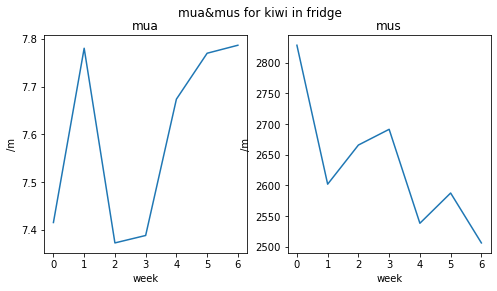

In [23]:
weeks_ = np.array([0,1,2,3,4,5,6,7])
mua = []
for i in range(len(avg_miu)):
    mua.append(avg_miu[i][0])
mus = []
for i in range(len(avg_miu)):
    mus.append(avg_miu[i][1])
fig = plt.figure(figsize = (8,4))
fig.suptitle('mua&mus for kiwi in fridge')
ax0=plt.subplot(1,2,1)
ax0.set_title('mua')
ax0.set_xticks(weeks_[0:AMOUNT_EXP])
ax0.set_xlabel('week')
ax0.set_ylabel('/m')
ax0.plot(weeks_[0:AMOUNT_EXP],mua)
ax1=plt.subplot(1,2,2)
ax1.set_title('mus')
ax1.set_xticks(weeks_[0:AMOUNT_EXP])
ax1.set_xlabel('week')
ax1.set_ylabel('/m')
ax1.plot(weeks_[0:AMOUNT_EXP],mus)
plt.show()

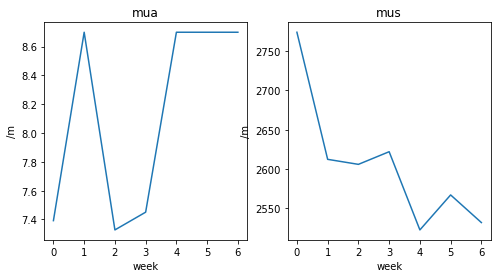

In [24]:
weeks_ = np.array([0,1,2,3,4,5,6,7])
mua = []
for i in range(len(mid_miu)):
    mua.append(mid_miu[i][0])
mus = []
for i in range(len(mid_miu)):
    mus.append(mid_miu[i][1])
plt.figure(figsize = (8,4))
ax0=plt.subplot(1,2,1)
ax0.set_title('mua')
ax0.set_xticks(weeks_[0:AMOUNT_EXP])
ax0.set_xlabel('week')
ax0.set_ylabel('/m')
ax0.plot(weeks_[0:AMOUNT_EXP],mua)
ax1=plt.subplot(1,2,2)
ax1.set_title('mus')
ax1.set_xticks(weeks_[0:AMOUNT_EXP])
ax1.set_xlabel('week')
ax1.set_ylabel('/m')
ax1.plot(weeks_[0:AMOUNT_EXP],mus)
plt.show()

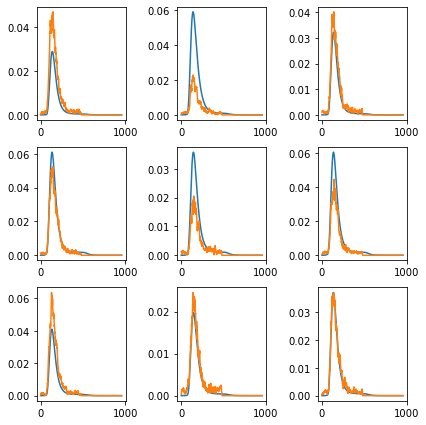

In [30]:
AMOUNT_i = 3
AMOUNT_j = 3
i_rand = random.sample(range(0,len(Y)), AMOUNT_i)
j_rand = random.sample(range(0,len(Y[0])), AMOUNT_j)
plt.figure(figsize = (6,6))
for i in range(AMOUNT_i):
    for j in range(AMOUNT_j):
        plt.subplot(3,3,i*AMOUNT_j+j+1)
        plt.plot(convolved[i_rand[i]][j_rand[j]]/1.4e11)
        plt.plot(Y[i_rand[i]][j_rand[j]])
    
plt.tight_layout(pad=1.0)
plt.show()